# Altcoin Price Prediction Project - Report
Can we predict the price of altcoin cryptocurrencies, and profit by trading them based on the forecast?

## Abstract

Either high-cap or low-cap cryptocurrencies are investment opportunities. This project's main objective is to develop models that are capable of predicting altcoin cryptocurrency close prices, as well as forecast prices. Altcoins generally have high volatility and large price swings, which are conducive to short-term trading. We look at short / long term trading and low-cap coins. Additionally, there a function will be utilize that measures the profit considering that there is a transaction fee to pay for each transaction. 
With cryptocurrency interest on the rise, there are many investment (short-term or long-term) opportunities to be had, especially due to the volatility of certain digital assets. The cryptocurrency market is tough to predict, just as the stock market, so we aim to create simple and complex models which are capable of forecasting low-cap coins and altcoins, which are generally subject to larger price swings. Using these models, the ultimate goal is to profit through trading these assets. We do this using autoregression, MACD and Bollinger Bands, and LSTM models. We test on historical price data of many different cryptocurrencies, and forecast using more recent data gathered from CoinAPI.

## Introduction

The objective is to build a model that informs an investor's decision making with regards to buying or selling cryptocurrency to make a profit. 

## Background

## Data

The analysis will only focus on the pricing information, leaving aside any factor which may impact the price of Bitcoin, like for example, news, which can play a very important rule. Price history is available on a daily basis from 2013. The datasets that are used for this project has the historical price information of some of the top crypto currencies by market capitalization.
- Date : date of observation
- Open : Opening price on the given day
- High : Highest price on the given day
- Low : Lowest price on the given day
- Close : Closing price on the given day
- Volume : Volume of transactions on the given day
- Market Cap : Market capitalization in USD

The data was derived from [Blockchain's website](http://www.blockchain.com/explorer), which includes the variables mentioned above. 

There are generally no missing values in the historical data, so no imputation is necessary. For autoregression, the data is loaded into a dataframe and a datetime index is created out of the date values provided. Additionally, the closing price, which is the only endogenous variable used in the autoregression model, is scaled using the natural logarithm, and time-series differenced.

## Methods

### Correlation among cryptocurrencies

In [ ]:
import preprocess_script as p
import glob
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

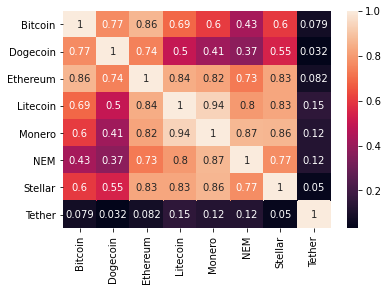

In [ ]:
df_corr = pd.read_csv('data\cryptocurrencypricehistory\coin_Bitcoin.csv').set_index('Date')[['Close']]
df_corr = df_corr.rename(columns={"Close":"Bitcoin"})
path = 'data/cryptocurrencypricehistory/*.csv'
columns = []
i= 0
for fname in glob.glob(path):
    i= i+1
    if i == 23:
        break
    data = pd.read_csv(fname).set_index('Date')
    cryptocurrency = fname.split('coin_')[1].split('.csv')[0]
    if len(data)>2000 and cryptocurrency != 'Bitcoin':
        data = data.rename(columns={"Close":cryptocurrency})
        columns.append(cryptocurrency)
        df_corr=pd.merge(df_corr,data[cryptocurrency], how='inner', left_index=True, right_index=True) 
corrMatrix = df_corr.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

#### Figure 1: Correlation matrix among cryptocurrencies' closing price

This has not been directly implemented or used as inputs to any of the models that were used in this project, however it has helped us build an understanding on the relationship among cryptocurrencies. Dogecoin, Ethereum, and Litcoin seem to have a strong correlation with Bitcoin. The next step, is to break the correlation matrix into 4 seasons, to see if it varies significantly.

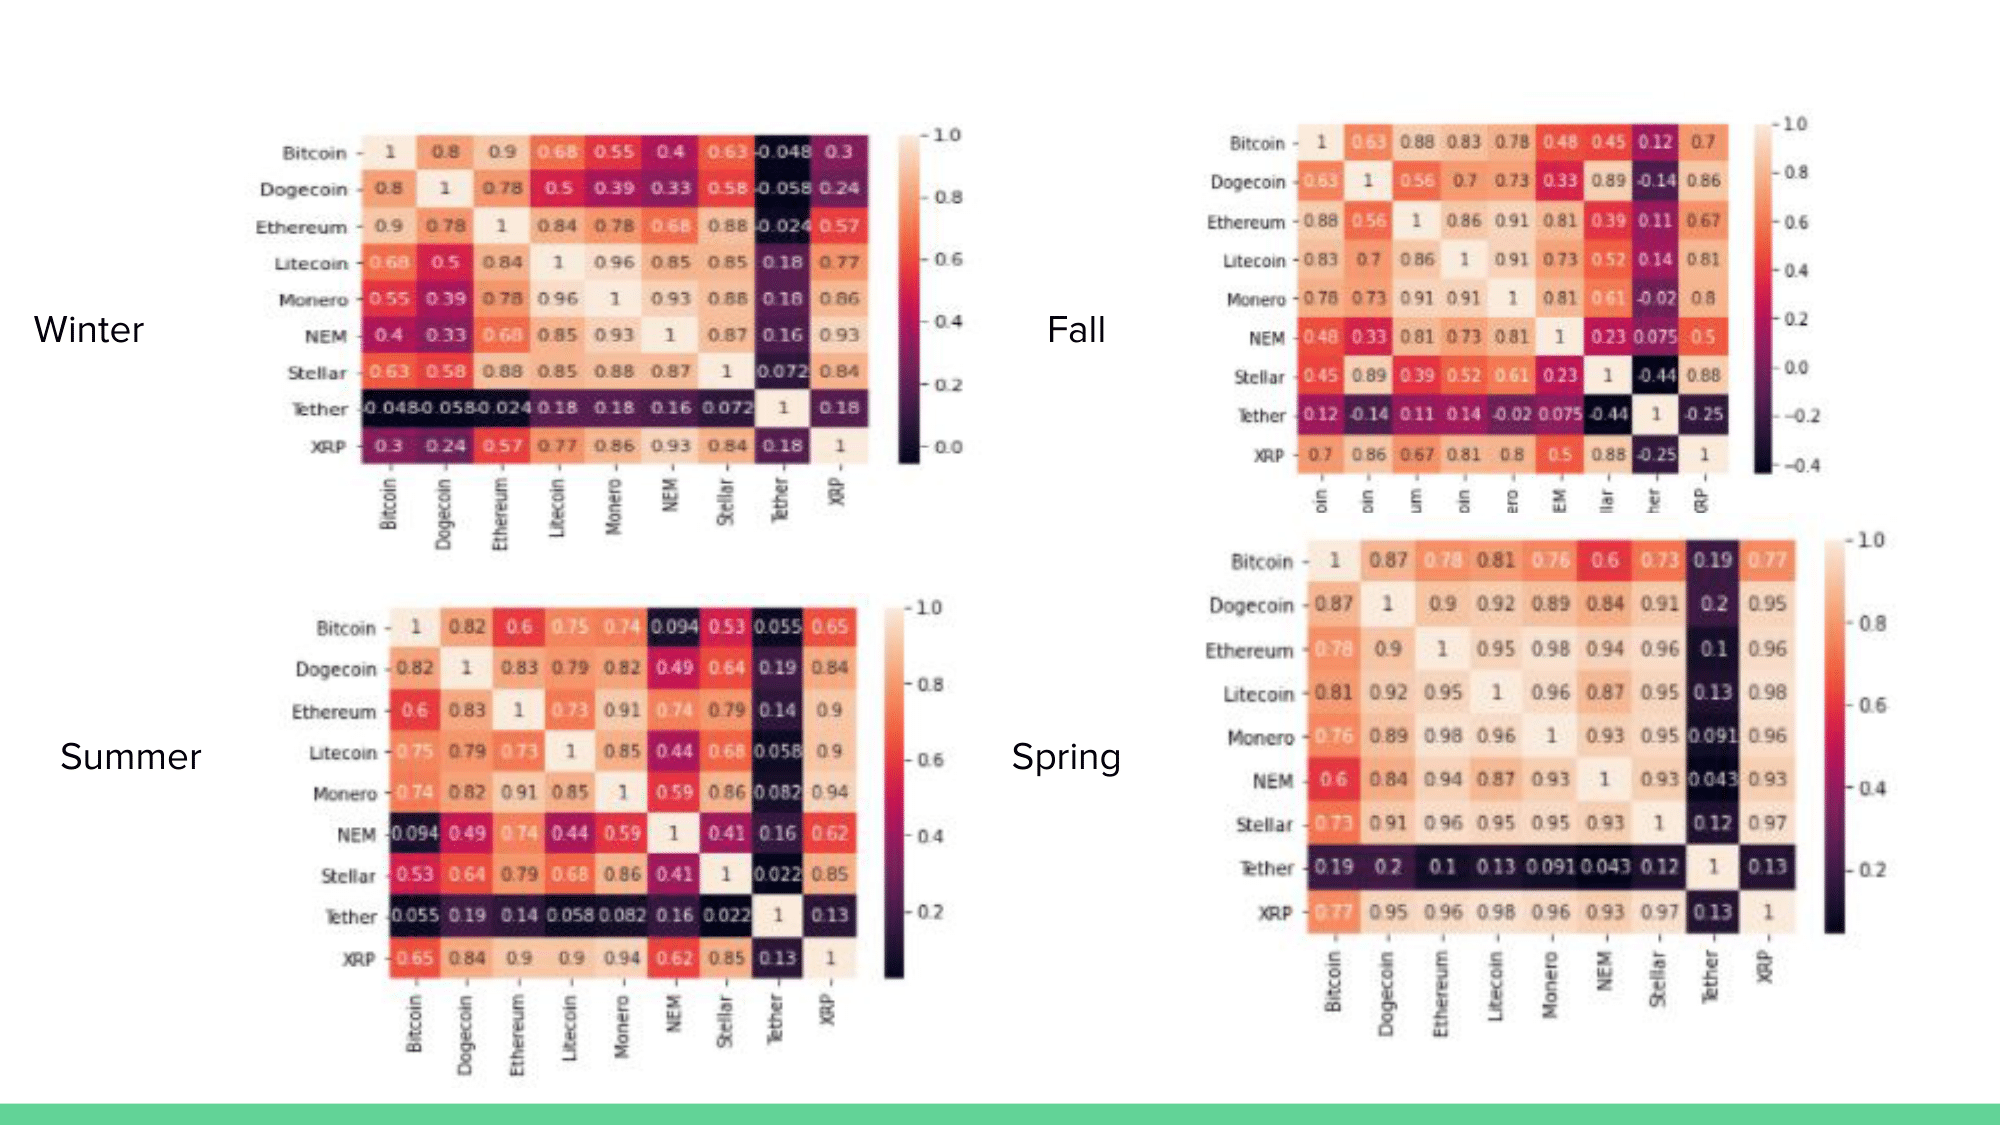

#### Figure 2: Correlation matrix among cryptocurrencies' closing price grouped by seasons

### Autoregression model

The most simple model to apply to this problem is an autoregression model, imported from the statsmodel python package. First, the close price feature variable of an example coin, Cardano / ADA, is explored visually through plots. Namely, a lag plot and an autocorrelation plot, to see if the time-series we have is suitable for autoregression.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
from statsmodels.tsa.ar_model import AutoReg
import matplotlib.dates as mdates
import datetime
from IPython.display import Markdown as md
df = pd.read_csv('data/cryptocurrencypricehistory/coin_Cardano.csv')
df['Date'] = pd.to_datetime(df['Date']).dt.date
df = df.set_index(pd.DatetimeIndex(df['Date'])).drop('Date', axis=1).drop('SNo', axis=1)
df.head()

,Name,Symbol,High,Low,Open,Close,Volume,Marketcap
Date,,,,,,,,
2017-10-02,Cardano,ADA,0.030088,0.019969,0.024607,0.025932,57641300.0,6.288991e+08
2017-10-03,Cardano,ADA,0.027425,0.020690,0.025757,0.020816,16997800.0,5.396927e+08
2017-10-04,Cardano,ADA,0.022806,0.020864,0.020864,0.021931,9000050.0,5.686195e+08
2017-10-05,Cardano,ADA,0.022154,0.020859,0.021951,0.021489,5562510.0,5.571390e+08
2017-10-06,Cardano,ADA,0.021542,0.018360,0.021359,0.018539,7780710.0,4.806646e+08


In [ ]:
pd.plotting.lag_plot(np.log(df['Close']))
plt.title('Lag Plot (Log Close Price)')

The correlation in the lag plot (lag of 1) suggests that an autoregressive model is appropriate. Next, the autocorrelation plot shows some possible values of lag orders for the model.

In [ ]:
pd.plotting.autocorrelation_plot(np.log(df['Close']))
plt.title('Autocorrelation Plot (Log Close Price)')

The autocorrelation plot shows that the correlation among the current value and the past ~200 values is statistically significant, and that the significance past a lag of 200 varies and may not be as significant as the previous values. Finally, an Augmented Dickey–Fuller test is used to test for stationarity of the data. The autoregression model should not be used on a non-stationary time series, so this is a way to see if we need to difference the close price series before training the model.

In [ ]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df['Close'].values)
print('ADF-Statistic:',adf_test[0])
print('p-value:',adf_test[1])
print('Critical Values', adf_test[4])

This suggests that the close price of ADA is not stationary. The pandas series method .diff() will be used to difference the close price.

In [ ]:
adf_test = adfuller(df['Close'].diff().dropna().values)
print('ADF-Statistic:',adf_test[0])
print('p-value:',adf_test[1])
print('Critical Values', adf_test[4])

This suggests that after differencing, the close price series is now stationary.

Now, a function is used to train the model over a range of lag values, and selects the best lag values by maximizing the hit rate, or the amount of days on which the model correctly predicts the sign of the percent change of the asset. Then, it minimizes the mean squared error of the predictions and selects the appropriate lag value, which also depends on the amount of days forecasted.

![Screenshot%202021-05-26%20012724.png](attachment:Screenshot%202021-05-26%20012724.png)

![download%20%281%29.png](attachment:download%20%281%29.png)

![download.png](attachment:download.png)

![download%20%282%29.png](attachment:download%20%282%29.png)

The model outputs a plot of the observed samples versus the predicted samples in the hold-out set, as well as a forecast based on the forecasted number of days input in the function, and a very rough trading guideline, which does not take into account profit-taking. Of course, the numbers here are the differenced values, so the

### LSTM Model 
Long-Short Term Memory (LSTM) is a type of RNN that allows us to process not only single data points (such as images) but also entire sequences of data (such as speech or video). They are a great choice for time series forecasting, and they are the type of architecture we will be using today. For this particular model, Dogecoin will be used as an experiment to test the model's performance. Let's begin by how the dataset looks like.

#### Experimenting with Dogecoin

In [ ]:
data = pd.read_csv('data/cryptocurrencypricehistory/coin_Dogecoin.csv')
df = data.set_index(pd.DatetimeIndex(data['Date']))
df = df[['Close']]
md("The data consists of {} observations, which means roughly {} years.".format(len(df),round(len(df)/365)))

The data consists of 2631 observations, which means roughly 7 years.

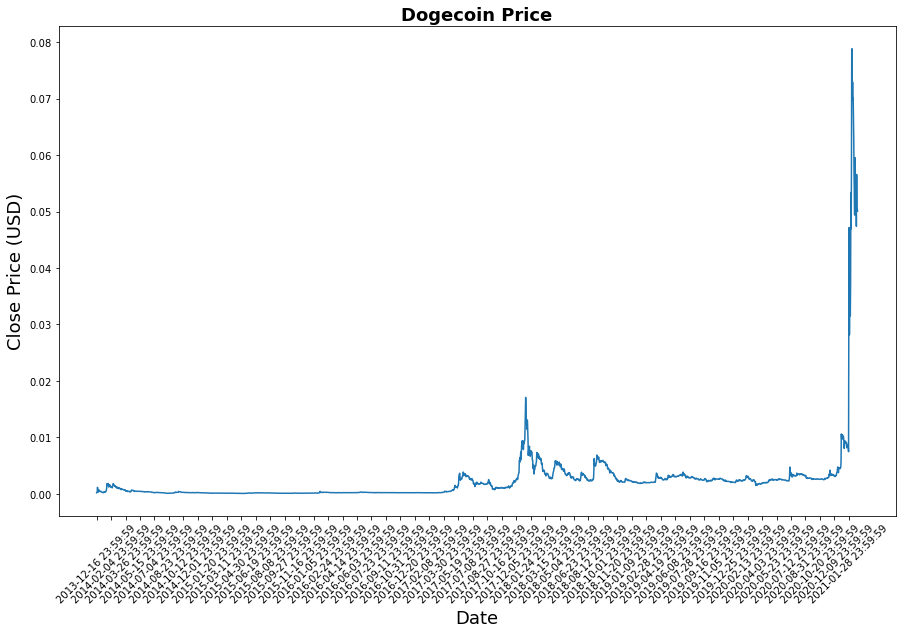

In [ ]:
price = data[['Close']]
plt.figure(figsize = (15,9))
plt.plot(price)
plt.xticks(range(0, data.shape[0],50), data['Date'].loc[::50],rotation=45)
plt.title("Dogecoin Price",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()

#### Figure 3: Closing price value of Dogecoin with respect of time. Each data point is a date.

#### Data preprocessing steps

In [ ]:
scaler = MinMaxScaler()
close_price = df.Close.values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)
scaled_close = scaled_close[~np.isnan(scaled_close)]
scaled_close = scaled_close.reshape(-1, 1)
X_train, y_train, X_test, y_test =\
 p.preprocess(scaled_close, 100, train_split = 0.99)

- Transform the closing price of the data using MinMaxScaler, so that the range of the values are from 0 to 1. This will help the model to converge
- Creating a sequence of a specified length at position 0. Each position is shifted to the right (1 step) and create another sequence. The process is done repeatedly until all positions in the training dataset are covered.
- Split data to train and testing set

## Evaluation

LSTM model performance

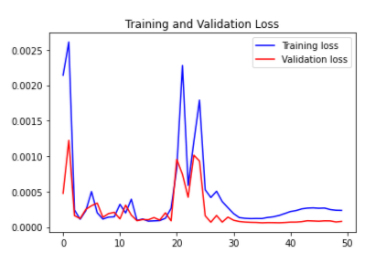

#### Figure 4: Train and Validation loss with respect to the number of epochs the model has performed
The cutoff was 15 epochs, where the training loss almost matched the validation loss. After 35 epochs the model seems to be overfitting.

## Conclusion

## Attribution